In [1]:
# import module
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import pyfits
import warnings

warnings.filterwarnings('ignore')

/Users/shohei/.pyenv/versions/3.6.4/lib/python3.6/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
# extract header/data
def extract_header(fname):
    hdu = pyfits.open(fname)[0]
    return hdu.header

def extract_data(fname):
    hdu = pyfits.open(fname)[0]
    return hdu.data
    
file_place = '/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Data/WISE/Second'
header_flat = [extract_header('{}/wise-w{}-flat.fits'.format(file_place, i)) for i in range(1, 5)]
header_msk = [extract_header('{}/wise-w{}-flat_msk.fits'.format(file_place, i)) for i in range(1, 5)]
header_unc = [extract_header('{}/wise-w{}-flat_unc.fits'.format(file_place, i)) for i in range(1, 5)]
data_flat = [extract_data('{}/wise-w{}-flat.fits'.format(file_place, i)) for i in range(1, 5)]
data_msk = [extract_data('{}/wise-w{}-flat_msk.fits'.format(file_place, i)) for i in range(1, 5)]
data_unc = [extract_data('{}/wise-w{}-flat_unc.fits'.format(file_place, i)) for i in range(1, 5)]

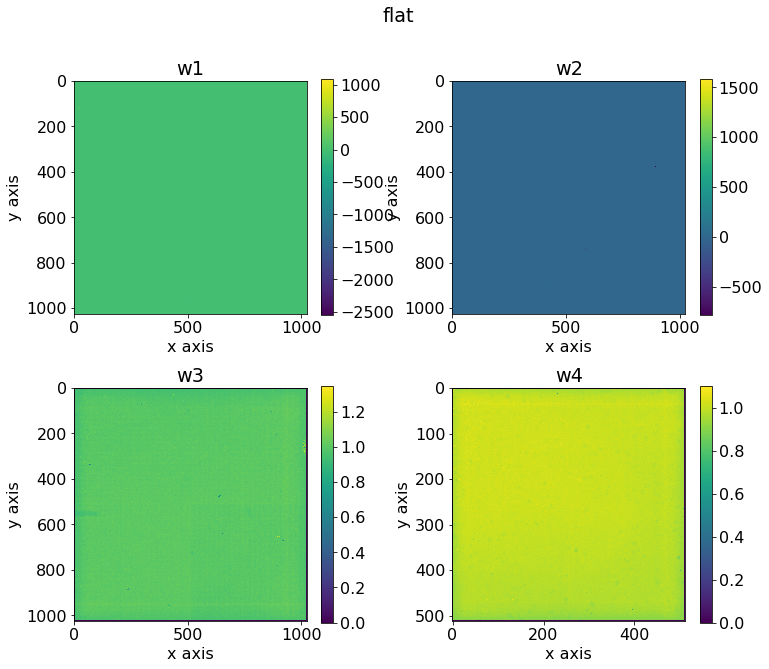

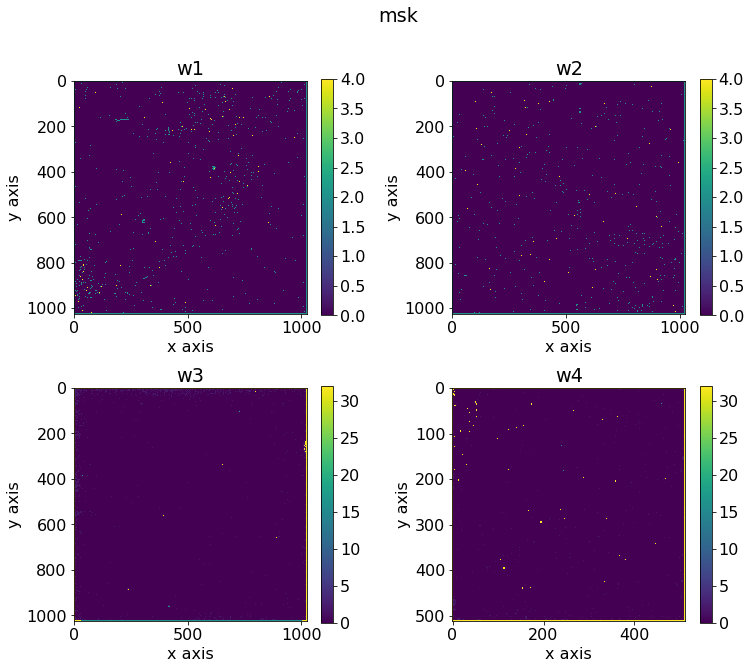

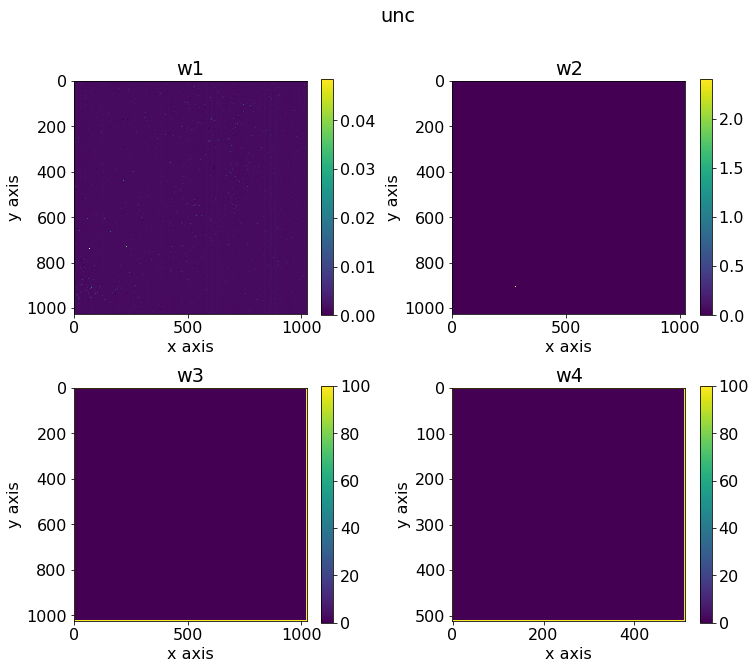

In [4]:
# snapshot
def subplot(i, data, n):
#    data[data>10] = 0
    plt.subplot(i)
    plt.imshow(data)
    plt.title('w{}'.format(n+1))
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.colorbar()

def imshow(data, title):
    plt.figure(figsize=(12, 10))
    plt.rcParams['font.size'] = 16
    [subplot(221+n, data[n], n) for n in range(4)]
    plt.suptitle(title)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
imshow(data_flat, 'flat')
imshow(data_msk, 'msk')
imshow(data_unc, 'unc')

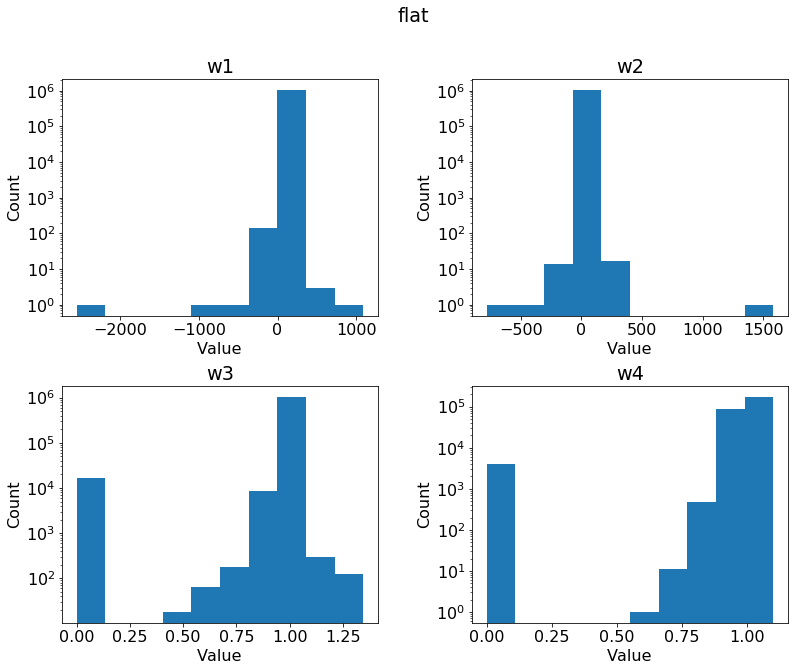

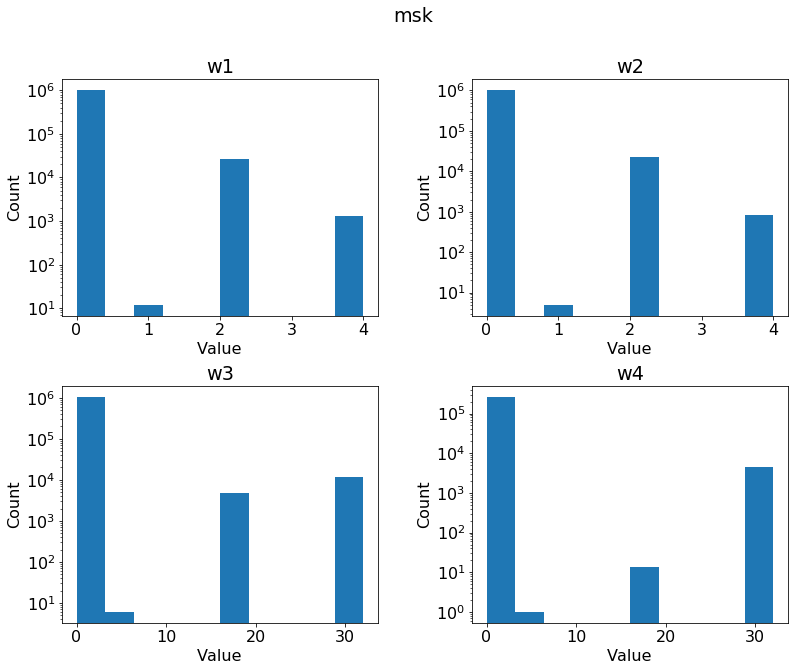

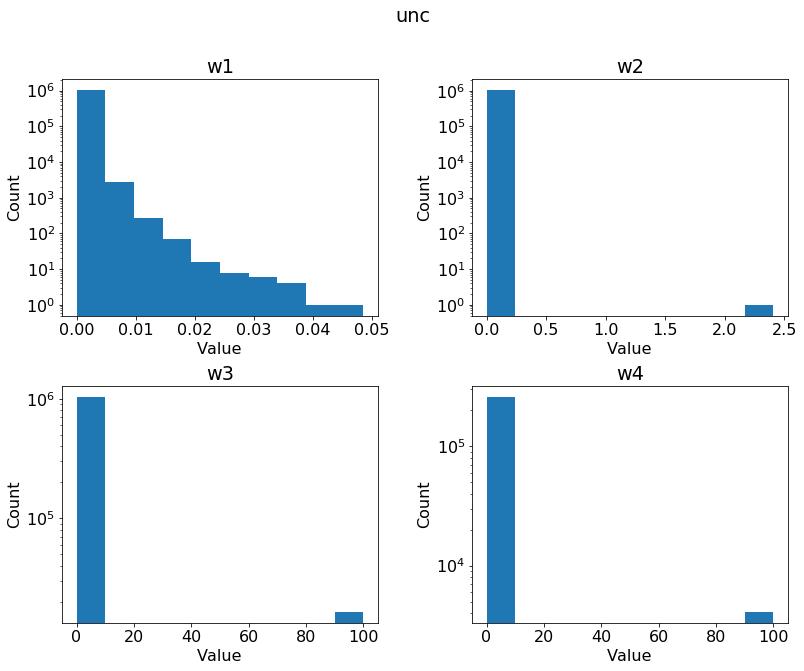

In [5]:
# histogram
def subplot(i, data, n):
    plt.subplot(i)
    plt.yscale('log')
    if n!=3:
        plt.hist(data.reshape((1024*1024, 1))[~np.isnan(data.reshape((1024*1024, 1)))])
    else:
        plt.hist(data.reshape((512*512, 1))[~np.isnan(data.reshape((512*512, 1)))])
    plt.title('w{}'.format(n+1))
    plt.xlabel('Value')
    plt.ylabel('Count')

def hist(data, title):
    plt.figure(figsize=(13, 10))
    plt.rcParams['font.size'] = 16
    [subplot(221+n, data[n], n) for n in range(4)]
    plt.suptitle(title)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()
    
hist(data_flat, 'flat')
hist(data_msk, 'msk')
hist(data_unc, 'unc')

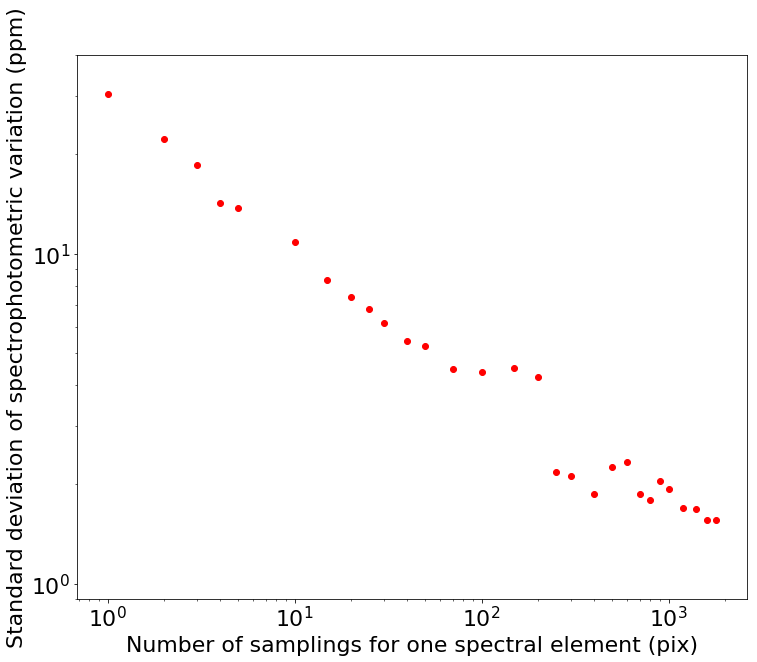

In [3]:
# residual(vertical)
def detector(data_unc, l, pix_start, pix_set):
    ver = pix_set[0]
    hor = pix_set[1]
    ver_start = pix_start[0]+ver*l
    ver_end = ver_start+ver
    hor_start = pix_start[1]
    hor_end = hor_start+hor
    data_unc_tar = data_unc[ver_start:ver_end, hor_start:hor_end]
    data_unc_tar = data_unc_tar[data_unc_tar<=0.002]
    return np.mean(data_unc_tar)

def residual(data_unc, lamb, pix_set):
    sci = np.array([detector(data_unc, l, sci_start, pix_set) for l in range(len(lamb))])
    back = np.array([detector(data_unc, l, back_start, pix_set) for l in range(len(lamb))])
    return sci-back

def standard_deviation(w1, w2, w3, pix_set):
    res1 = residual(data_unc[w1-1], lamb[lamb<6], pix_set)
    res2 = residual(data_unc[w2-1], lamb[(lamb>=6)&(lamb<11)], pix_set)
    res3 = residual(data_unc[w3-1], lamb[lamb>=11], pix_set)
    return np.hstack((res1, res2, res3)).std()*10**6
    
lamb = np.load('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Simulation/Primary/Revise/Data/lamb.npy')
sci_start = [215, 212]
back_start = [215, 612]
pixel_set = np.array([[1, 1],
                      [1, 2],
                      [1, 3],
                      [1, 4],
                      [1, 5],
                      [1, 10],
                      [1, 15],
                      [1, 20],
                      [1, 25],
                      [1, 30],
                      [1, 40],
                      [1, 50],
                      [1, 70],
                      [1, 100],
                      [1, 150],
                      [1, 200],
                      [2, 125],
                      [2, 150],
                      [2, 200],
                      [4, 125],
                      [3, 200],
                      [4, 175],
                      [4, 200],
                      [5, 180],
                      [5, 200],
                      [6, 200],
                      [7, 200],
                      [8, 200],
                      [9, 200]
                     ])

x = [pix_set[0]*pix_set[1] for pix_set in pixel_set]
y = [standard_deviation(3, 3, 3, pix_set) for pix_set in pixel_set]

fig = plt.figure(figsize=(12, 10))
plt.rcParams['font.size'] = 22
ax = fig.add_subplot(111)
ax.plot(x, y, 'ro')
ax.set_xlabel('Number of samplings for one spectral element (pix)')
ax.set_ylabel('Standard deviation of spectrophotometric variation (ppm)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(0.9, 40)
#plt.savefig('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Manuscript/flat_field.pdf')
plt.show()

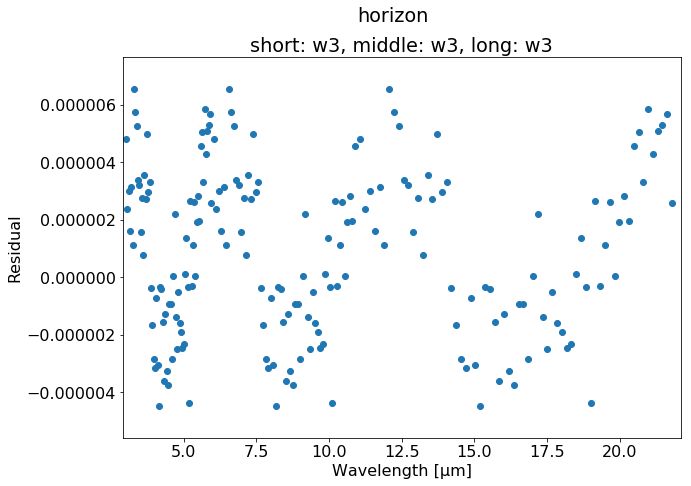

In [24]:
# residual(horizon)
lamb = np.load('/Users/shohei/Desktop/Shohei/Fresnel/Detector/Paper/Simulation/Primary/Revise/Data/lamb.npy')
hor = 200
ver = 9
sci_start = [215, 212]
back_start = [215, 612]

def detector(w, data_unc, data_msk, l, pix_start):
    ver_start = pix_start[0]+ver*l
    ver_end = ver_start+ver
    hor_start = pix_start[1]
    hor_end = hor_start+hor
    data_unc_tar = data_unc[ver_start:ver_end, hor_start:hor_end]
    data_msk_tar = data_msk[ver_start:ver_end, hor_start:hor_end]
    #data_unc_tar = data_unc_tar[np.where(data_msk_tar==0)]
    data_unc_tar = data_unc_tar[data_unc_tar<=0.002]
    return data_unc_tar.mean()

def residual(w, data_unc, data_msk, lamb):
    sci = np.array([detector(w, data_unc, data_msk, l, sci_start) for l in range(len(lamb))])
    back = np.array([detector(w, data_unc, data_msk, l, back_start) for l in range(len(lamb))])
    return sci-back

def subplot(i, w_1, w_2, w_3):
    res1 = residual(w_1, data_unc[w_1].T, data_msk[w_1].T, lamb[lamb<6])
    res2 = residual(w_2, data_unc[w_2].T, data_msk[w_2].T, lamb[(lamb>=6)&(lamb<11)])
    res3 = residual(w_3, data_unc[w_3].T, data_msk[w_3].T, lamb[lamb>=11])
    res = np.hstack((res1, res2, res3))
    res_width = res.max()-res.min()
    plt.subplot(i)
    plt.scatter(lamb, res)
    plt.title('short: w{}, middle: w{}, long: w{}'.format(w_1+1, w_2+1, w_3+1))
    plt.xlabel('Wavelength [µm]')
    plt.ylabel('Residual')
    plt.xlim(2.9, 22.1)
    plt.ylim(res.min()-res_width*0.1, res.max()+res_width*0.1)
    
plt.figure(figsize=(10, 7))
plt.rcParams['font.size'] = 16
subplot(111, 2, 2, 2)
#subplot(231, 0, 0)
#subplot(232, 0, 1)
#subplot(233, 0, 2)
#subplot(234, 1, 1)
#subplot(235, 1, 2)
#subplot(236, 2, 2)
plt.suptitle('horizon')
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()